In [17]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class PointSampler(Module):
    def __init__(
        self,
        focal: float,
        height: int,
        width: int,
        points_per_ray: int,
        device: Device,
    ):
        """
        `[4, 4] => [height, width, points_per_ray, 3 + 3 + 1]`
        """

        super(PointSampler, self).__init__()

        import torch

        focal = float(focal)
        height = int(height)
        width = int(width)
        points_per_ray = max(int(points_per_ray), 1)

        self.directions = torch.stack(
            torch.meshgrid(
                (torch.arange(float(width), device=device) - width / 2.0) / focal,
                (-torch.arange(float(height), device=device) + height / 2.0) / focal,
                torch.tensor(-1.0, device=device),
                indexing="xy",
            ),
            dim=-1,
        )
        self.points_per_ray = points_per_ray

    def forward(
        self,
        posture: Tensor,
        distance_range: tuple[float, float],
        is_random: bool,
    ) -> Tensor:
        import torch

        posture = torch.as_tensor(posture)[:3]
        device = posture.device
        distance_range = tuple(map(float, distance_range))
        is_random = bool(is_random)
        distance_max = max(distance_range)
        distance_min = min(distance_range)
        interval = (distance_max - distance_min) / self.points_per_ray

        directions = (self.directions * posture[:, :3]).sum(dim=-1).unsqueeze(-2)
        origins = posture[:, -1].expand_as(directions)
        distances = (
            torch.linspace(
                distance_min,
                distance_max,
                self.points_per_ray,
                device=device,
            )
            .repeat(
                (*origins.shape[:-2], 1),
            )
            .unsqueeze(-1)
        )
        if is_random:
            distances += (
                torch.rand(*origins.shape[:-2], self.points_per_ray, 1, device=device)
                * interval
            )
        points = origins + directions * distances
        directions = directions.expand_as(points)
        return torch.cat([points, directions, distances], dim=-1)

In [18]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class PositionalEncoder(Module):
    def __init__(self, encoding_factor: int, device: Device):
        """
        `[..., input_dimension] => [..., input_dimension * (2 * encoding_factor + 1)]`
        """

        import torch

        super(PositionalEncoder, self).__init__()

        encoding_factor = max(int(encoding_factor), 0)

        freq_lvls = torch.arange(encoding_factor, device=device)
        self.freq = ((2**freq_lvls) * torch.pi).repeat_interleave(2).unsqueeze_(-1)
        sine_offsets = torch.tensor([0.0, torch.pi / 2], device=device)
        self.offsets = sine_offsets.repeat(encoding_factor).unsqueeze_(-1)

    def forward(self, inputs: Tensor) -> Tensor:
        import torch

        inputs = torch.as_tensor(inputs).unsqueeze(-2)

        features = (self.freq * inputs + self.offsets).sin()
        features = torch.cat([inputs, features], dim=-2)
        features = features.reshape(*inputs.shape[:-2], -1)
        return features

    def get_last_dimension(self, input_dimension: int) -> int:
        return int(input_dimension) * (self.freq.shape[0] + 1)

In [19]:
from torch.nn import Module


class ColorPredictor(Module):
    def __init__(self, device: Device):
        """
        `[..., 3 + 3 + 1] => [..., 4]`
        """

        super(ColorPredictor, self).__init__()

        from torch.nn import Linear, ModuleList, ReLU, Sigmoid

        ENCODING_FACTOR = 20
        self.encode = PositionalEncoder(ENCODING_FACTOR, device=device)

        I = 3 + 3 + 1
        I = self.encode.get_last_dimension(I)

        O = 4
        H = 256

        self.layers = ModuleList(
            [
                Linear(I, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H + I, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H, H, device=device),
                ReLU(),
                Linear(H, O, device=device),
            ]
        )
        self.output_rgb_activation = Sigmoid()
        self.output_alpha_activation = ReLU()

        self.skip_indexs = {
            8,
        }

    def forward(self, inputs: Tensor) -> Tensor:
        import torch

        inputs = self.encode(inputs)
        outputs = inputs

        for index, layer in enumerate(self.layers):
            if index in self.skip_indexs:
                outputs = torch.cat([outputs, inputs], dim=-1)
            outputs = layer(outputs)
        outputs = torch.cat(
            [
                self.output_rgb_activation(outputs[..., :3]),
                self.output_alpha_activation(outputs[..., 3:]),
            ],
            dim=-1,
        )
        return outputs

In [20]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class VolumeRenderer(Module):
    def __init__(
        self,
        focal: float,
        height: int,
        width: int,
        points_per_ray: int,
        device: Device,
    ):
        """
        `[4, 4] => [height, width, 3]`
        """

        super(VolumeRenderer, self).__init__()

        self.sample = PointSampler(
            focal=focal,
            height=height,
            width=width,
            points_per_ray=points_per_ray,
            device=device,
        )
        self.predict = ColorPredictor(device=device)

    def forward(
        self,
        posture: Tensor,
        rays_per_batch: int,
        distance_range: tuple[float, float],
        is_random: bool,
    ) -> Tensor:
        import torch
        from torch.utils.data import DataLoader

        rays_per_batch = max(int(rays_per_batch), 1)

        points_per_batch = rays_per_batch * self.sample.points_per_ray
        points: Tensor = self.sample(posture, distance_range, is_random)
        colors = torch.cat(
            [
                self.predict(batch)
                for batch in DataLoader(
                    dataset=points.reshape(-1, points.shape[-1]),
                    batch_size=points_per_batch,
                )
            ],
            dim=0,
        )
        colors = colors.reshape(*points.shape[:-1], -1)
        rgb = colors[..., :3]
        alpha = colors[..., 3]

        distances = points[..., -1]
        intervals = torch.cat(
            [
                distances[..., 1:] - distances[..., :-1],
                torch.tensor([1e9], device=distances.device).expand_as(
                    distances[..., -1:]
                ),
            ],
            dim=-1,
        )
        alpha = 1.0 - torch.exp(-alpha * intervals)
        transmittance = (alpha * torch.cumprod(1.0 - alpha + 1e-10, -1)).unsqueeze(-1)
        rgb_planar = (rgb * transmittance).sum(dim=-2)

        return rgb_planar

In [21]:
from dataclasses import dataclass
from torch import Tensor
from torch.types import Device


@dataclass
class ViewSynthesisDataset:
    count: int
    focal: float
    height: int
    images: Tensor
    postures: Tensor
    width: int

    def __post_init__(self) -> None:
        if self.images.shape[0] != self.postures.shape[0]:
            raise ValueError("The number of images and postures must be the same")

    @staticmethod
    def from_numpy(url: str) -> "ViewSynthesisDataset":
        from httpx import get
        from io import BytesIO
        from numpy import load

        import torch

        try:
            file = BytesIO(
                get(url, follow_redirects=True, timeout=60).raise_for_status().content
            )
        except:
            file = open(url, "rb")

        with file as file_entered:
            arrays = load(file_entered)
            focal = float(arrays["focal"])
            images = torch.as_tensor(arrays["images"])
            postures = torch.as_tensor(arrays["poses"])

        return ViewSynthesisDataset(
            count=images.shape[0],
            focal=focal,
            height=images.shape[1],
            images=images,
            postures=postures,
            width=images.shape[2],
        )

    def get_image_and_posture(self, index: int | None = None) -> tuple[Tensor, Tensor]:
        from random import randint

        if index is not None:
            index = int(index)
        else:
            index = randint(0, self.count - 1)

        return self.images[index], self.postures[index]

    def set_device(self, device: Device) -> "ViewSynthesisDataset":
        self.images = self.images.to(device)
        self.postures = self.postures.to(device)
        return self

    def __repr__(self) -> str:
        repr = f"{self.__class__.__name__}("
        for name, value in self.__dict__.items():
            if isinstance(value, Tensor):
                value = f"Tensor(shape={tuple(value.shape)}, dtype={value.dtype})"
            elif type(value) is float:
                value = f"{value:.7f}"
            repr += f"\n  {name}={value},"
        repr += "\n)"
        return repr

In [22]:
class Trainer:
    def __init__(
        self,
        dataset: ViewSynthesisDataset,
        train_ratio: float,
        device: Device,
    ):
        train_data_count = max(int(round(dataset.count * train_ratio)), 1)
        test_data_count = dataset.count - train_data_count
        data_split_index = -test_data_count
        focal = dataset.focal
        height = dataset.height
        images = dataset.images
        postures = dataset.postures
        width = dataset.width

        self.test_dataset = ViewSynthesisDataset(
            count=test_data_count,
            focal=focal,
            height=height,
            images=images[data_split_index:],
            postures=postures[data_split_index:],
            width=width,
        ).set_device(device)

        self.train_dataset = ViewSynthesisDataset(
            count=train_data_count,
            focal=focal,
            height=height,
            images=images[:data_split_index],
            postures=postures[:data_split_index],
            width=width,
        ).set_device(device)

    def train(
        self,
        render: VolumeRenderer,
        epochs: int,
        rays_per_batch: int,
        distance_range: tuple[float, float],
        show_progress: bool,
    ) -> None:
        import torch
        from torch.nn import MSELoss
        from torch.optim import Adam
        from tqdm import tqdm

        EPOCHS_PER_DEMO = 20

        criterion = MSELoss()
        optimizer = Adam(render.parameters(), lr=5e-4)
        progress = tqdm(
            disable=not show_progress,
            desc=f"Fitting the renderer to {self.train_dataset.count}x images and postures",
            colour="green",
            dynamic_ncols=True,
            total=epochs,
        )

        with progress:
            for epoch in range(epochs):
                true_image, posture = self.train_dataset.get_image_and_posture()
                optimizer.zero_grad()
                rendered_image: Tensor = render(
                    posture=posture,
                    rays_per_batch=rays_per_batch,
                    distance_range=distance_range,
                    is_random=True,
                )
                loss = criterion(rendered_image, true_image)
                loss.backward()
                optimizer.step()

                if show_progress and epoch % EPOCHS_PER_DEMO == 0:
                    with torch.no_grad():
                        true_image_demo, posture_demo = (
                            self.train_dataset.get_image_and_posture(0)
                        )
                        rendered_image_demo = render(
                            posture=posture_demo,
                            rays_per_batch=rays_per_batch,
                            distance_range=distance_range,
                            is_random=False,
                        )
                        Trainer.display(
                            torch.cat([true_image_demo, rendered_image_demo], dim=1)
                        )

                progress.update()

    def test(
        self,
        render: VolumeRenderer,
        rays_per_batch: int,
        distance_range: tuple[float, float],
    ) -> None:
        import torch
        from torch.nn.functional import mse_loss

        with torch.no_grad():
            for index in range(self.test_dataset.count):
                true_image, posture = self.test_dataset.get_image_and_posture(index)
                rendered_image = render(
                    posture=posture,
                    rays_per_batch=rays_per_batch,
                    distance_range=distance_range,
                    is_random=False,
                )
                quality_mse = mse_loss(rendered_image, true_image).item()
                quality_psnr = -10 * torch.log10(quality_mse)
                display(
                    dict(
                        test_index=index,
                        quality=dict(mse=quality_mse, psnr=quality_psnr),
                    )
                )

                Trainer.display(torch.cat([true_image, rendered_image], dim=1))

    @staticmethod
    def display(image: Tensor):
        from IPython.display import display
        from PIL import Image
        from torch import uint8

        return display(
            Image.fromarray((image * 255).round().type(uint8).numpy(force=True))
        )

In [23]:
def main() -> None:
    from torch import cuda, save
    
    EPOCHS = 1000
    RAYS_PER_BATCH = 1024
    POINTS_PER_RAY = 16
    DISTANCE_RANGE = (2.0, 6.0)

    dataset = ViewSynthesisDataset.from_numpy(
        "https://raw.githubusercontent.com/AsherJingkongChen/nerf/main/tiny_nerf_data.npz"
    )
    device = "cuda" if cuda.is_available() else "mps"
    render = VolumeRenderer(
        focal=dataset.focal,
        height=dataset.height,
        width=dataset.width,
        points_per_ray=POINTS_PER_RAY,
        device=device,
    )
    trainer = Trainer(dataset=dataset, train_ratio=0.8, device=device)

    display(dict(dataset=dataset, render=render))

    trainer.train(
        render=render,
        epochs=EPOCHS,
        rays_per_batch=RAYS_PER_BATCH,
        distance_range=DISTANCE_RANGE,
        show_progress=True,
    )
    trainer.test(
        render=render,
        rays_per_batch=RAYS_PER_BATCH,
        distance_range=DISTANCE_RANGE,
    )
    save(render.state_dict(), "VolumeRenderer.pth")

{'dataset': ViewSynthesisDataset(
   count=106,
   focal=138.8888789,
   height=100,
   images=Tensor(shape=(106, 100, 100, 3), dtype=torch.float32),
   postures=Tensor(shape=(106, 4, 4), dtype=torch.float32),
   width=100,
 ),
 'render': VolumeRenderer(
   (sample): PointSampler()
   (predict): ColorPredictor(
     (encode): PositionalEncoder()
     (layers): ModuleList(
       (0): Linear(in_features=287, out_features=256, bias=True)
       (1): ReLU()
       (2): Linear(in_features=256, out_features=256, bias=True)
       (3): ReLU()
       (4): Linear(in_features=256, out_features=256, bias=True)
       (5): ReLU()
       (6): Linear(in_features=543, out_features=256, bias=True)
       (7): ReLU()
       (8): Linear(in_features=256, out_features=256, bias=True)
       (9): ReLU()
       (10): Linear(in_features=256, out_features=256, bias=True)
       (11): ReLU()
       (12): Linear(in_features=256, out_features=256, bias=True)
       (13): ReLU()
       (14): Linear(in_features=2

Fitting the renderer to 85x images and postures:   0%|          | 0/1000 [00:00<?, ?it/s]

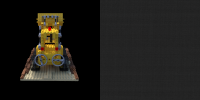

Fitting the renderer to 85x images and postures:   2%|▏         | 20/1000 [00:08<06:35,  2.48it/s]

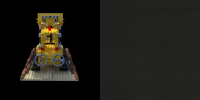

Fitting the renderer to 85x images and postures:   4%|▍         | 40/1000 [00:16<05:32,  2.89it/s]

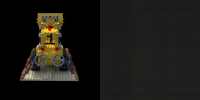

Fitting the renderer to 85x images and postures:   6%|▌         | 60/1000 [00:23<05:17,  2.96it/s]

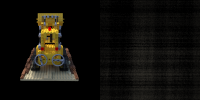

Fitting the renderer to 85x images and postures:   8%|▊         | 80/1000 [00:30<05:10,  2.97it/s]

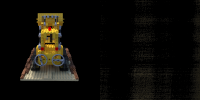

Fitting the renderer to 85x images and postures:  10%|█         | 100/1000 [00:38<05:04,  2.96it/s]

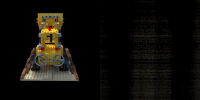

Fitting the renderer to 85x images and postures:  12%|█▏        | 120/1000 [00:45<05:19,  2.75it/s]

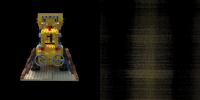

Fitting the renderer to 85x images and postures:  14%|█▎        | 136/1000 [00:51<05:15,  2.74it/s]

In [24]:
if __name__ == "__main__":
    main()